In [ ]:
# Upgrade Oracle ADS to pick up latest features and maintain compatibility with Oracle Cloud Infrastructure.

!pip install -U oracle-ads

Oracle Data Science service sample notebook.

Copyright (c) 2021 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

---

# <font color="red">Text Extraction Using the Accelerated Data Science (ADS) SDK</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:

The Accelerated Data Science (ADS) SDK provides a text extraction module. This module allows you to convert PDF and Microsoft Word files into plain text. The data is stored in Pandas dataframes so you can easily manipulate and save it. In this notebook, you read files of various file formats, and convert them into different formats to use for text manipulation. The notebook reviews several of the most common `DataLoader` commands and showcases some advanced features such as defining custom backend and file processor.

Compatible conda pack: [Natural Language Processing](https://docs.oracle.com/iaas/data-science/using/conda-nlp-fam.htm) for CPU on Python 3.7 (version 2.0)

***

## Contents:

- <a href="#intro">Introduction</a>
    - <a href="#intro_config">Configuring the Input Data Source</a>
- <a href="#load">Load a Corpse</a>
    - <a href="#load_read">Read a Dataset</a>
- <a href="#read">Corpus Read Options</a>
    - <a href="#read_read_line">The `.read_line()` Method</a>
        - <a href="#read_read_line_callable">Example: Python Callable `udf`</a>
        - <a href="#read_read_line_regex">Example: Regular Expression `udf`</a>
    - <a href="#read_read_text">The `.read_text()` Method</a>
        - <a href="#read_read_text_total_files">Example: `total_files`</a>
    - <a href="#read_convert_to_text">The `.convert_to_text()` Method</a>
    - <a href="#read_metadata_all">The `.metadata_all()` Method</a>
    - <a href="#read_metadata_schema">The `.metadata_schema()` Method</a>
- <a href="#augment">Augment the Records</a>
    - <a href="#augment_file_name">Example: Using `Options.FILE_NAME`</a>
    - <a href="#augment_file_name">Example: Using `Options.FILE_METADATA`</a>
- <a href="#custom">Custom File Processor and Backend</a>
    - <a href="#custom_backend">Custom Backend</a>
    - <a href="#custom_file_processor">Custom File Processor</a>
    - <a href="#custom_example">Example: Create a Custom File Processor and Backend</a>
- <a href="#reference">References</a>

---


Datasets are provided as a convenience.  Datasets are considered third-party content and are not considered materials 
under your agreement with Oracle.
    
You can access the `pdf_sample` dataset license [here](https://oss.oracle.com/licenses/upl).

In [ ]:
import ads
import fsspec
import oci
import os
import pandas as pd
import shutil
import time
import tempfile

from ads.text_dataset.backends import Base
from ads.text_dataset.dataset import TextDatasetFactory as textfactory
from ads.text_dataset.extractor import FileProcessor, FileProcessorFactory
from ads.text_dataset.options import Options
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

ads.set_debug_mode()
ads.set_auth("resource_principal")

<a id="intro"></a>
# Introduction

Text extraction is the process of extracting text from one document and converting it into another form, typically plain text. For example, you can extract the body of text from a PDF document that has figures, tables, images, and text. The process can also be used to extract metadata about the document. Generally, text extraction takes a corpus of documents and returns the extracted text in a structured format. In the ADS text extraction module, that format is a Pandas dataframe.

The Pandas dataframe has a record in each row. That record can be an entire document, a sentence, a line of text, or some other unit of text. In this notebook, you explore using a row to indicate a line of text and an entire document.

The ADS text extraction module supports:

- Input formats: `text`, `pdf`, and `docx` or `doc`.
- Output formats: Use `pandas` for Pandas dataframe, or `cudf` for a cuDF dataframe.
- Backends: [Apache Tika](https://tika.apache.org/) (default), and [pdfplumber](https://github.com/jsvine/pdfplumber) (for PDF).
- Source location: Local block volume, and in cloud storage such as the Oracle Cloud Infrastructure (OCI) Object Storage.
- Options to extract metadata.

You can manipulate files using the `DataLoader` object. Some of the most common commands are:

- `.read_line()`: Read files line-by-line. Each line corresponds to a record in the corpus.
- `.read_text()`: Read files where each file corresponds to a record in the corpus.
- `.convert_to_text()`: Convert document to text, and then save them as plain text files.
- `.metadata_all()` and `.metadata_schema()`: Extract metadata from each file.

<a id="intro_config"></a>
## Configuring the Input Data Source

The OCI Data Science service has a corpus of text documents that are used in this notebook. This corpus is stored in a publically accessible OCI Object Storage bucket. The following variables define the Object Storage namespace and the bucket name. You can update these variables to point at your Object Storage bucket, but you might also have to change some of the code in the notebook so that the keys are correct.

In [ ]:
namespace = "bigdatadatasciencelarge"
bucket = "hosted-ds-datasets"

<a id="load"></a>
# Load a Corpse

The `TextDatasetFactory` class, which is aliased to `textfactory` in this notebook, provides access to the `DataLoader` and `FileProcessor` objects. The `DataLoader` object is a file format-specific object for reading in documents such as PDF and Word documents. Internally, a data loader binds together a file system interface (in this case [fsspec](https://filesystem-spec.readthedocs.io/en/latest/)) for opening files. The `FileProcessor` object is used to convert these files into plain text. It also has an `engine` object to control the output format. For a given `DataLoader` object, you can customize both the `FileProcessor` and `engine`.

Generally, the first step in reading a corpus of documents is to obtain a `DataLoader` object. For example, `TextDatasetFactory.format('pdf')` returns a `DataLoader` for PDFs. Likewise, you can get a Word document loaders by passing in `docx` or `doc`. You can choose an engine that controls how the data is returned. The default engine is a Python generator. If you want to use the data as a dataframe, then use the `.engine()` method. A call to `.engine('pandas')` returns the data as a Pandas dataframe. On a GPU machine, you can use cuDF dataframes with a call to `.engine('cudf')`.

The `.format()` method controls the backend with [Apache Tika](https://tika.apache.org/) and [pdfplumber](https://github.com/jsvine/pdfplumber) being built-in. In addition, you can write your own backend and plug it into the system. This allows you complete control over the backend. The file processor is used to actually process a specific file format. 

This figure shows the relationship between the various backends and file processors: 

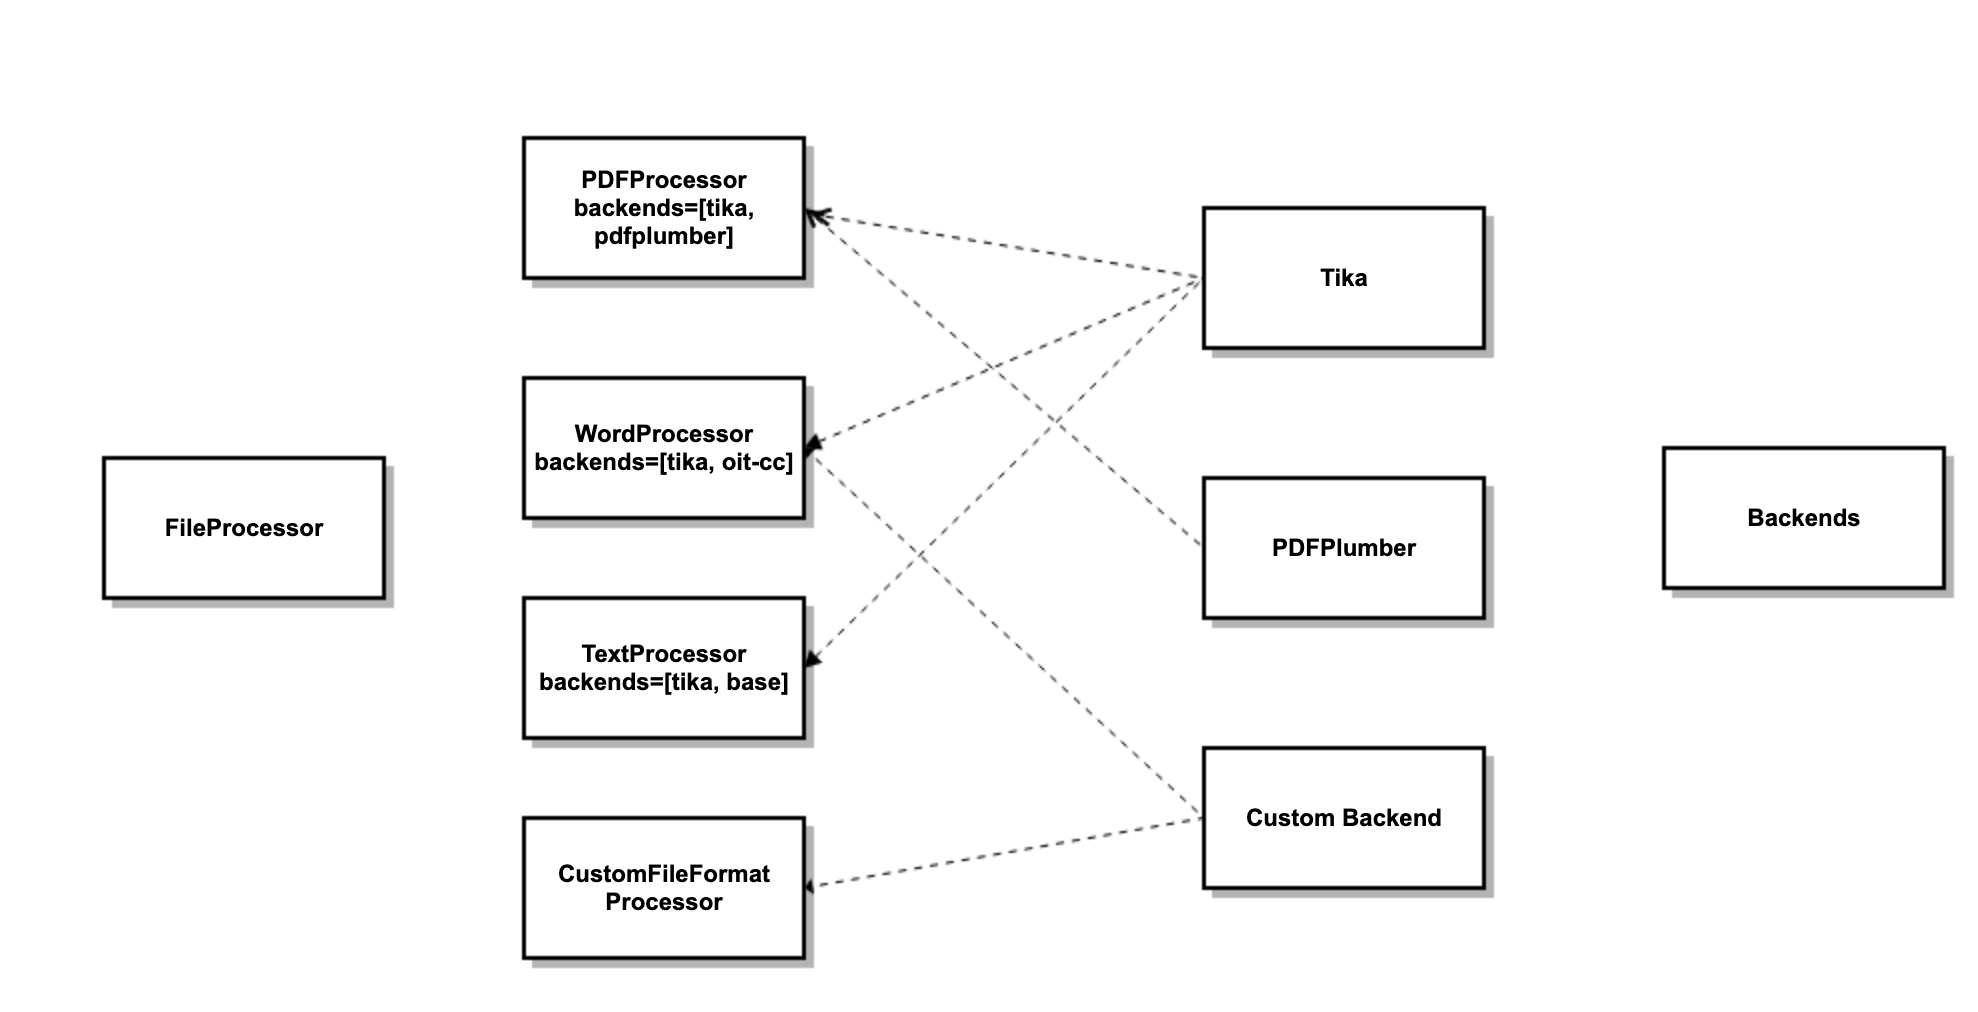

Notice that there is a many-to-many relationship between the backends and file processors. This means that a given file format can support multiple backends, and a backend can support multiple file formats.

To obtain a `DataLoader` object, call the use the `.format()` method on `textfactory`. This will return a `DataLoader` object that can then be configured with the `.backend()`, `.engine()`, and `.options()` methods. The `.backend()` method is used to define which backend is to manage the process of parsing the corpse. If this is not specified then a sensible default backend is chosen based on the file format that is being processed. The `.engine()` method is used to control the output format of the data. If it is not specified, then an iterator is returned. The `.options()` method is used to add extra fields to each record. These would be things such as the filename, or metadata about the file. There are more details about this and the other configuration methods in the notebook.

<a id="load_read"></a>
## Read a Dataset

In this example, you create a `DataLoader` object by calling `textfactory.format('pdf')`. This `DataLoader` object is configured to read PDF documents. You then change the backend to use [pdfplumber](https://github.com/jsvine/pdfplumber) with the method `.backend('pdfplumber')`. It's easier to work with the results if they are in a dataframe. So, the method `.engine('pandas')` returns a Pandas dataframe.

After you have the `DataLoader` object configured, you process the corpus. In this example, the corpus is a single PDF file. It's read from a publicly accessible OCI Object Storage bucket. The `.read_line()` method is used to read in the corpus where each line of the document is treated as a record. Thus, each row in the returned dataframe is a line of text from the corpus.

In [ ]:
dl = textfactory.format("pdf").backend("pdfplumber").engine("pandas")
df = dl.read_line(
    f"oci://{bucket}@{namespace}/pdf_sample/paper-0.pdf",
    storage_options={"config": {}},
)
df.head()

<a id="read"></a>
# Corpus Read Options

Typically, you want to treat each line of a document or each document as a record. The `.read_line()` method processes a corpus, and returns each line in the documents as a text string. The `.read_text()` method treats each document in the corpus as a record.

Both the `.read_line()` and `.read_text()` methods parse the corpus, convert it to text, and reads it into memory. The `.convert_to_text()` method does the same processing as `.read_text()`, but it outputs the plain text to files. This allows you to post-process the data without having to convert the raw documents *again* into plain text documents, which can be an expensive process.

Each document can have a custom set of metadata that describes the document. The `.metadata_all()` and `.metadata_schema()` methods allow you to access this metadata. Metadata is represented as a key-value pair. The `.metadata_all()` returns a set of key-value pairs for each document. The `.metadata_schema()` method returns what keys are used in defining the metadata. This can vary from document to document, and this method creates a list of all observed keys. You use this to understand what metadata is available in the corpus.


<a id="read_read_line"></a>
## The `.read_line()` Method

The `.read_line()` method allows you to read a corpus line-by-line. In other words, each line in a file corresponds to one record. The only required argument to this method is `path`. It sets the path to the corpus, and it can contain a glob pattern. For example, `oci://{bucket}@{namespace}/pdf_sample/**.pdf`, `'oci://{bucket}@{namespace}/20news-small/**/[1-9]*'`, or `/home/datascience/<path-to-folder>/[A-Za-z]*.docx` are all valid paths that contain a glob pattern for selecting multiple files. The `path` parameter can also be a list of paths. This allows for reading files from different file paths.

The optional `udf` parameter stands for user-defined function. This parameter can be a callable Python object, or a regular expression (RegEx). If it is a callable Python object, then the function must accept a string as an argument and returns a tuple. If the parameter is a RegEx, then the record is ignored. This is a convenient method to selectively capture text from a corpus. In either case, the `udf` is applied on the record level, and is a powerful tool for data transformation and filtering.
The `.read_line()` method has the following arguments:

- `df_args`: Arguments to pass to the engine. It only applies to Pandas and cuDF dataframes.
- `n_lines_per_file`: Maximal number of lines to read from a single file.
- `path`: The path to the corpus.
- `storage_options`: Options that are necessary for connecting to OCI Object Storage.
- `total_lines`: Maximal number of lines to read from all files.
- `udf`: User-defined function for data transformation and filtering.

<a id="read_read_line_callable"></a>
### Example: Python Callable `udf`

In the next cell, a `lambda` function is used to create a Python callable object, that is passed to the `udf` parameter. The `lambda` function takes a line and splits it based on white space to tokens. It then counts the number of tokens, and returns a tuple where the first element is the token count and the second element is the line itself.

The `df_args` parameter is used to change the column names into user-friendly values.

In [ ]:
dl = textfactory.format("docx").engine("pandas")
df = dl.read_line(
    path=f"oci://{bucket}@{namespace}/docx_sample/*.docx",
    udf=lambda x: (len(x.strip().split()), x),
    storage_options={"config": {}},
    df_args={"columns": ["token count", "text"]},
)
df.head()

<a id="read_read_line_regex"></a>
### Example: Regular Expression `udf`

In this example, the corpus is a collection of log files. A RegEx is used to parse the standard Apache log format. If a line doesn't match the pattern, it's discarded. If it does match the pattern, then a tuple is returned where each element is a value in the RegEx [capture group](https://www.regular-expressions.info/brackets.html).

This example uses the default engine which returns an iterator. The `next()` method is used to iterate through the values:

In [ ]:
APACHE_LOG_PATTERN = (
    r"^\[(\S+)\s(\S+)\s(\d+)\s(\d+\:\d+\:\d+)\s(\d+)]\s(\S+)\s(\S+)\s(\S+)\s(\S+)"
)
dl = textfactory.format("txt")
df = dl.read_line(
    f"oci://{bucket}@{namespace}/log_sample/*.log",
    udf=APACHE_LOG_PATTERN,
    storage_options={"config": {}},
)
next(df)

<a id="read_read_text"></a>
## The `.read_text()` Method

It you want to treat each document in a corpus as a record, use the `.read_text()` method. The `path` parameter is the only required parameter and it defines the location of the corpus, see <a href="#read_read_line"> the `.read_line()` method</a> section for more details.

The optional `udf` parameter stands for user-defined function. This parameter can be a callable Python object or a RegEx, see <a href="#read_read_line"> the `.read_line()` method</a> section for more details.

The `.read_text()` method has the following arguments:

- `df_args`: Arguments to pass to the engine. It only applies to Pandas and cuDF dataframes.
- `path`: The path to the corpus.
- `storage_options`: Options that are necessary for connecting to OCI Object Storage.
- `total_files`: The maximum number of files that should be processed.
- `udf`: User-defined function for data transformation and filtering.

<a id="read_read_text_total_files"></a>
### Example: `total_files`

In this example, the are six files in the corpus. However, the parameter `total_files` is set to 4 so only the first four files are processed. There is no guarantee which four will actually be processed. However, this parameter is commonly used to limit the size of the data when you are developing the code for the model. Later on, it is often removed so the entire corpus is processed.

This example also demonstrates the use of a list, plus globbing, to define the corpus. Notice that the `path` parameter is a list with two file paths. The output shows the dataframe has four rows and so only four files were processed.

In [ ]:
dl = textfactory.format("docx").engine("pandas")
df = dl.read_text(
    path=[
        f"oci://{bucket}@{namespace}/docx_sample/*.docx",
        f"oci://{bucket}@{namespace}/docx_sample/*.doc",
    ],
    total_files=4,
    storage_options={"config": {}},
)
df.shape

<a id="read_convert_to_text"></a>
## The `.convert_to_text()` Method

Converting a set of raw documents can be an expensive process. The `.convert_to_text()` method allows you to convert a corpus of source documents, and write them out as plain text files. Each document input document is written to a separate file that has the same name as the source file. However, the file extension is changed to `.txt`. Converting the raw documents this way allows you to post-process the raw text multiple times while only have to convert it once.

The `src_path` parameter defines the location of the corpus, see <a href="#read_read_line"> the `.read_line()` method</a> section for more details. The `dst_path` parameter gives the location where the plain text files are to be written. It can be an Object Storage bucket or the local block storage. If the directory does not exist it is created. It overwrites any files in the directory.

The `.convert_to_text()` method has the following arguments:

- `dst_path`: Object Storage or the local block storage path where plain text files are written.
- `encoding`: Encoding for files. The default is `utf-8`.
- `src_path`: The path to the corpus.
- `storage_options`: Options that are necessary for connecting to Object Storage.

The next cell converts a corpus, and writes it to a temporary directory. It then lists all the plain text files that were created in the conversion process.

In [ ]:
dst_path = tempfile.mkdtemp()
dl = textfactory.format("pdf")
dl.convert_to_text(
    src_path=f"oci://{bucket}@{namespace}/pdf_sample/*.pdf",
    dst_path=dst_path,
    storage_options={"config": {}},
)
print(os.listdir(dst_path))
shutil.rmtree(dst_path)



Each document can contain metadata. The purpose of the `.metadata_all()` method is to capture this information for each document in the corpus. There is no standard set of metadata across all documents so each document could return different set of values. 

The `path` parameter is the only required parameter as it defines the location of the corpus.

The `.metadata_all()` method has the following arguments:

- `encoding`: Encoding for files. The default is `utf-8`.
- `path`: The path to the corpus.
- `storage_options`: Options that are necessary for connecting to Object Storage.

The next cell processes a corpus of PDF documents using `pdfplumber`, and prints the metadata for the first document.

In [ ]:
dl = textfactory.format("pdf").backend("pdfplumber").option(Options.FILE_NAME)
metadata = dl.metadata_all(
    path=f"oci://{bucket}@{namespace}/pdf_sample/Emerging Infectious Diseases copyright info.pdf",
    storage_options={"config": {}},
)
next(metadata)

The backend that you use can affect what metadata is returned. For example, the Tika backend returns more metadata than `pdfplumber`, and also the names of the metadata elements are also different. The next cell processes the same PDF document as previously used, but you can see that there is a difference in the metadata.

In [ ]:
dl = textfactory.format("pdf").backend("default")
metadata = dl.metadata_all(
    path=f"oci://{bucket}@{namespace}/pdf_sample/Emerging Infectious Diseases copyright info.pdf",
    storage_options={"config": {}},
)
next(metadata)

<a id="read_metadata_schema"></a>
## The `.metadata_schema()` Method

As briefly discussed in the <a href="#read_metadata_all"> `.metadata_all()` method</a> section, there is no standard set of metadata across all documents. The `.metadata_schema()` method is a convience method that returns what metadata is avalible in the corpus. It returns a list of all observed metadata fields in the corpus. Since each document can have a different set of metadata, all the values returned may not exist in all documents. Notice that the engine used can return different metadata for the same document, see <a href="#read_metadata_all">the `.metadata_all()` method</a> for an example of this.

The `path` parameter is the only required parameter as it defines the location of the corpus, see the <a href="#read_read_line">`.read_line()` method</a> section for more details.

Often, you don't want to process an entire corpus of documents to get a sense of what metadata is available. Generally, the engine returns a fairly consistent set of metadata. The `n_files` option is quite handy because it limits the number of files that are processed.

The `.metadata_schema()` method has the following arguments:

- `encoding`: Encoding for files. The default is `utf-8`.
- `n_files`: Maximum number of files to process. The default is 1.
- `path`: The path to the corpus.
- `storage_options`: Options that are necessary for connecting to Object Storage.

The next cell uses the `.metadata_schema()` method to collect the metadata fields on the first two files in the corpus. The `n_files=2` parameter is used to control the number of files that are processed.

In [ ]:
dl = textfactory.format("pdf").backend("pdfplumber")
schema = dl.metadata_schema(
    f"oci://{bucket}@{namespace}/pdf_sample/*.pdf",
    storage_options={"config": {}},
    n_files=2,
)
print(schema)

<a id="augment"></a>
# Augment the Records

The `text_dataset` module has the ability to augment the returned records with additional information using the `.option()` method. This method takes an enum from the `Options` class. The `.option()` method can be used multiple times on the same `DataLoader` to select a set of additional information that is returned. The `Options.FILE_NAME` enum returns the filename that is associated with the record. The `Options.FILE_METADATA` allows you to extract individual values from the document's metadata. Notice that the engine used can return different metadata for the same document, see the <a href="#read_metadata_all">`.metadata_all()` method</a> for an example of this.

<a id="augment_file_name"></a>
## Example: Using `Options.FILE_NAME`

The next cell uses `.option(Options.FILE_NAME)` to augment to add the filename of each record that is returned. The example uses the `txt` for the `FileProcessor`, and Tika for the backend. The engine is Pandas so a dataframe is returned. The `df_args` options are used to rename the columns of the dataframe. Notice that the returned dataframe has a column named `path`. This is the information that was added to the record from the `.option(Options.FILE_NAME)` method.

In [ ]:
dl = (
    textfactory.format("txt").backend("tika").engine("pandas").option(Options.FILE_NAME)
)
df = dl.read_text(
    path=f"oci://{bucket}@{namespace}/20news-small/**/[1-9]*",
    storage_options={"config": {}},
    df_args={"columns": ["path", "text"]},
)
df.head()

<a id="augment_file_name"></a>
## Example: Using `Options.FILE_METADATA`

You can add metadata about a document to a record using `.option(Options.FILE_METADATA, {'extract': ['<key1>, '<key2>']})`. When you use `Options.FILE_METADATA`, there is a required second parameter. It takes a dictionary where the key is the action to be taken. In the next cell, the key `extract` provides a list of metadata that can be extracted. When a list is used, the returned value is also a list of the metadata values. The next cell uses repeated calls to `.option()` where different metadata values are extracted. In this case, a list is not returned, but each value is in a separate Pandas column.

In [ ]:
dl = (
    textfactory.format("docx")
    .engine("pandas")
    .option(Options.FILE_METADATA, {"extract": ["meta:character-count"]})
    .option(Options.FILE_METADATA, {"extract": ["meta:paragraph-count"]})
    .option(Options.FILE_METADATA, {"extract": ["dc:creator"]})
)
df = dl.read_text(
    path=f"oci://{bucket}@{namespace}/docx_sample/*.docx",
    storage_options={"config": {}},
    df_args={"columns": ["character count", "paragraph count", "author", "content"]},
)
df.head()

<a id="custom"></a>
# Custom File Processor and Backend

The `text_dataset` module supports several file processors and backends. However, it's not practical to provide these for all possible documents. So, the `text_dataset` allows you to create your own.

When creating a custom file processor, you must register it with ADS using the
`FileProcessorFactory.register()` method. The first parameter is the name that you want to associate with the file processor. The second parameter is the class that is to be registered. There is no need to register the backend class.

<a id="custom_backend"></a>
## Custom Backend

To create a backend, you need to develop a class that inherits from the `ads.text_dataset.backends.Base` class. In your class, you need to overload any of the following methods that you want to use with `.read_line()`, `.read_text()`, `.convert_to_text()`, and `.get_metadata()`. The `.get_metadata()` method must be overloaded if you want to use the `.metadata_all()` and `.metadata_schema()` methods in your backend.

The `.convert_to_text()` method takes a file handler, destination path, filename, and storage options as parameters. This method must write the plain text file to the destination path, and return the path of the file.

The `.get_metadata()` method takes a file handle as an input parameter, and returns a dictionary of the metadata. The `.metadata_all()` and `.metadata_schema()` methods don't need to overload because they use the `.get_metadata()` method to return their results.

The `.read_line()` method must take a file handle, and have a `yield` statement that returns a plain text line from the document.

The `.read_text()` method has the same requirements as the `.read_line()` method, except it must `yield` the entire document as plain text.

The following are the method signatures:
```python
convert_to_text(self, fhandler, dst_path, fname, storage_options)
get_metadata(self, fhandler)
read_line(self, fhandler)
read_text(self, fhandler)
```

<a id="custom_file_processor"></a>
## Custom File Processor

To create a custom file processor, you must develop a class that inherits from `ads.text_dataset.extractor.FileProcessor`. Generally, there are no methods that need to be overloaded. However, the class variable `backend_map` has to be defined. This is a dictionary where the key is the name of the format that it supports, and the value is the file processor class. There must be a key called, `default`, for use when no file processor is defined for the `DataLoader`. An example of the `backend_map` is:
```python
backend_map = {'default': MyCustomBackend, 'tika': Tika, 'custom': MyCustomBackend}
```

<a id="custom_example"></a>
## Example: Create a Custom File Processor and Backend

In the next cell, you create a custom backend class called `ReverseBackend`. It overloads the `.read_line()` and `.read_text()` methods. This toy backend returns the records in reverse order.

The `TextReverseFileProcessor` class is used to create a new file processor that is used with the backend. This class has the `backend_map` class variable that maps the backend label to the backend object. In this case, the only format that is provided is the default class.

Having defined the (`TextReverseBackend`) backend and file processor (`TextReverseFileProcessor`) classes, the format must be registered. You register it with the `FileProcessorFactory.register('text_reverse', TextReverseFileProcessor)` command where the first parameter is the format and the second parameter is the file processor class.

In [ ]:
class TextReverseBackend(Base):
    def read_line(self, fhandler):
        with fhandler as f:
            for line in f:
                yield line.decode()[::-1]

    def read_text(self, fhandler):
        with fhandler as f:
            yield f.read().decode()[::-1]


class TextReverseFileProcessor(FileProcessor):
    backend_map = {"default": TextReverseBackend}


FileProcessorFactory.register("text_reverse", TextReverseFileProcessor)

Having created the custom backend and file processor, you use the `.read_line()` method to read in one record and print it:

In [ ]:
dl = textfactory.format("text_reverse")
reverse_text = dl.read_line(
    f"oci://{bucket}@{namespace}/20news-small/rec.sport.baseball/100521",
    total_lines=1,
    storage_options={"config": {}},
)
text = next(reverse_text)[0]
print(text)

The `.read_line()` method in the `TextReverseBackend` class reversed the characters in each line of text that is processed. You can confirm this by reversing it back:

In [ ]:
text[::-1]

<a id="reference"></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)